# Transformers tutorial

<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G/blob/main/days/w1d3/transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instructions**:
- Read the preliminary readings

- Answer the questions in each section of the notebook

- For all torch Modules defined in the notebook:
  - Hide the forward method, write a forward2 method using the properties defined at initialization. 
  - Once forward2 is coded, check your code by opening forward again, compare.
  - test forward2 by renaming it to forward and run the full notebook to see if your dimensions are compatible
  - ignore the dropout layers and device management for now. 

**Preliminary readings**:
- High level explication:  https://huggingface.co/course/chapter1/1?fw=pt
- Transformer tuto: https://jalammar.github.io/illustrated-transformer/ 
- Bonus: Paper: Attention is all you need, https://arxiv.org/abs/1706.03762, section Architecture

**First questions**:
- What was the original purpose of the transformer architecture?
- What are its current uses?
- Informally, what is the purpose of an encoder? What is the purpose of a decoder?

**Instructions**:
- Go to Colab Settings (top-right) > Editor > Activate the line numerotations and activate the reduction of the code in the editor.
- Hide (reduce the code) off all forward methods containing the solution, write a forward2 method using the properties defined at initialization. 
- Once forward2 is coded, check your code by opening forward again, compare.
- test forward2 by renaming it to forward and run the full notebook to see if your dimensions are compatible.
- **ignore the dropout layers, device management, and the masks for now.**

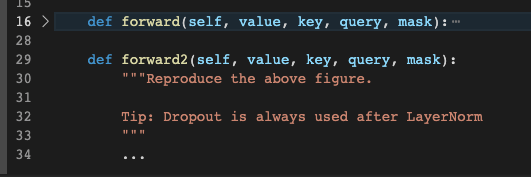

## Self Attention

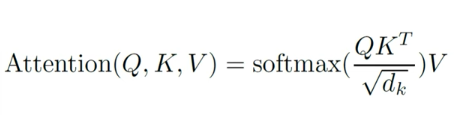

**Notations**:
- b: batch size
- i: sequence len in
- o: sequence len out
- e: embedding dimension

There are 3 types of attention mecanisms in "Attention is all you need":
- Encoder Attention: values, keys and queries are of shape (b, i, e)
- Encoder-Decoder Attention: values and keys come from encoder (b, i, e), queries comes from decoder (b, o, e)
- Decoder Masked Attention: values, keys and queries come from the output sequence (b, o, e)

We will create a SelfAttention Module that will be usable by those 3 types of attentions.

**Question**: 
- Meditate on the meanings of values, keys and queries.
- Explain why we need to softmax on the keys' dimension?

**Bonus Questions**:
- Why do keys and values always go together?
- Write the attention formula with einsum for QK^T matrices of dimension (b, seq_len, embed_size)
- What happens to the attention in the encoder, in the decoder, in the encoder-decoder attention?
- In the SelfAttention class, self.values = nn.Linear(self.embed_size, self.embed_size, bias=False) : ie, all heads attentions are stored in the same matrix.
  - What would you do if there was only one head attention?
- use einops (https://github.com/arogozhnikov/einops) instead of pytorch operations.
- meditate on the sequence of information transfers for each dimension.

In [ ]:
%pip install einops -q

In [ ]:
import torch
import torch.nn as nn
import einops

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        # Attention weights of the different heads are stored in the same tensors.

        # We put all the attention heads in the same Linears Layers:
        self.values = nn.Linear(self.embed_size, self.embed_size, bias=False)
        self.keys = nn.Linear(self.embed_size, self.embed_size, bias=False)
        self.queries = nn.Linear(self.embed_size, self.embed_size, bias=False)

        # fc_out after having concatenated the results of the attention of each head
        self.fc_out = nn.Linear(self.embed_size, embed_size)

    def init2(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = self.embed_size//self.heads
        assert (self.head_dim * self.heads == self.embed_size )
        
        self.values = nn.Linear(self.embed_size, self.embed_size, bias = False)
        self.queries = nn.Linear(self.embed_size, self.embed_size, bias = False)
        self.keys = nn.Linear(self.embed_size, self.embed_size, bias = False)

        self.fc_out = nn.Linear(self.embed_size, self.embed_size)

    def forward(self, values, keys, queries, mask):
        """
        values: (N, value_len, embed_size)
        keys: (N, keys_len, embed_size)
        queries: (N, queries_len, embed_size)

        mask: None or (N, heads, query_len, key_len) 
        if mask == 0, attention matrix  -> float("-1e20") (big negative value)
        Ignore the mask, it's too difficult at the beginning.
        """
        # Get number of training examples
        N = queries.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]

        # Compute the values keys and queries
        values = self.values(values)  # (N, value_len, embed_size)
        keys = self.keys(keys)  # (N, key_len, embed_size)
        queries = self.queries(queries)  # (N, query_len, embed_size)

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)

        # Compute the similarity between query*keys
        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for better stability
        attention = torch.softmax(energy / (self.head_dim ** (1 / 2)), dim=3)
        # attention shape: (N, heads, query_len, key_len)


        # We compute the attention (aka the ponderated value)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.


        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)
        return self.fc_out(out)
    
    def forward2(self, values, keys, queries, mask):
        """
        values: (N, value_len, embed_size)
        keys: (N, keys_len, embed_size)
        queries: (N, queries_len, embed_size)

        mask: None or (N, heads, query_len, key_len) 
        if mask == 0, attention matrix  -> float("-1e20") (big negative value)
        Ignore the mask, it's too difficult at the beginning.
        """
        N = queries.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]

        # Compute the values keys and queries
        values = self.values(values)
        queries = self.queries(queries)
        keys = self.keys(keys)

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        queries = queries.reshape(N, key_len, self.heads, self.head_dim)
        keys = keys.reshape(N, query_len, self.heads, self.head_dim)


        # Compute the similarity between query*keys
        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm
        energy = torch.einsum("Nqhd,Nkhd -> Nhqk" , [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)


        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))


        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for better stability
        attention = torch.softmax(energy / (self.head_dim ** (1 / 2)), dim=-1)
        # attention shape: (N, heads, query_len, key_len)


        # We compute the attention
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.


        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)
        return self.fc_out(out)

## Encoder Block

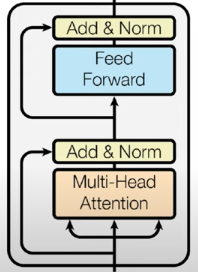

**Question**: 
- Why normalization is always after the addition operation?

**Bonus**:
- The output of the multi-head attention is the attention tensor. In the Add & Norm, should we add with the query, key or value?
- Which dimension of the tensor is critical in the attention? (Choose between batch dimension, sequence len, and embeddings dimension)
- Which dimension of the tensor is critical in the feed-forward layer?

(critical means: the information flows along this dimension)


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        """Reproduce the above figure.
        
        Tip: Dropout is always used after LayerNorm
        """
        attention = self.attention(value, key, query, mask)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out
    
    def forward2(self, value, key, query, mask):
        """Reproduce the above figure.
        
        Tip: Dropout is always used after LayerNorm
        """
        attention = self.attention(values, key, query, mask)
        attention_res_norm = self.dropout(self.norm1(attention + query))
        out = self.norm2(self.feed_forward(attention_res_norm) + attention_res_norm)
        return self.dropout(out)

## Encoder

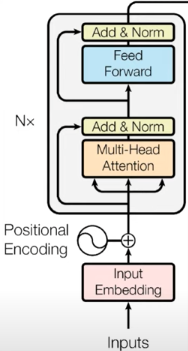

In the paper attention is all you need, the position embedding  ses sines. We won't implement this part: let the neural network learn the position embedding by itself.

**Tip**: Use torch.expand(*target_dim) to broadcast with repetitions.

**Bonus Question** : Why do we use ModuleList and not torch.nn.Sequential?

In [ ]:

class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):

        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        """
        x: Tokenized tensor (N, seq_length) containing tokens_ids
        mask: Used for masking the padding inside the encoder.

        Create the position_embedding/word_embedding
        add the embeddings and forward it the all the layers.

        Tip: In order to create the position_embedding, you will need torch.arange and tensor.expand
        """
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        position_embedding = self.position_embedding(positions)
        word_embedding = self.word_embedding(x)
        out = self.dropout(position_embedding + word_embedding)

        # In the Encoder the query, key, value are all the same, it's in the
        # decoder this will change. This might look a bit odd in this case.
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out
    
    def forward2(self, x, mask):
        """
        x: Tokenized tensor (N, seq_length) containing tokens_ids
        mask: Used for masking the padding inside the encoder.

        Create the position_embedding/word_embedding
        add the embeddings and forward it the all the layers.

        Tip: In order to create the position_embedding, you will need torch.arange and tensor.expand
        """
        N, seq_len = x.shape
        pos_emb = self.position_embedding(torch.arange(seq_len).expand(N,seq_len).to(self.device))
        out = (self.word_embedding(x) + pos_emb)
        for transformer in self.layers:
          out = transformer(out, out, out, mask) 
        return out       
        

## Decoder Block

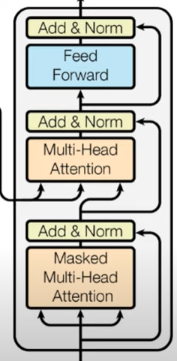

In the decoder block, you have to implement the Masked Multi head Attention, but then we can reuse the Encoder Block

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.norm = nn.LayerNorm(embed_size)
        self.attention = SelfAttention(embed_size, heads=heads)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        """DecoderBlock = masked multi-head attention + TransformerBlock"""
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out
    
    def forward2(self, x, value, key, src_mask, trg_mask):
        """DecoderBlock = masked multi-head attention + TransformerBlock"""
        attention = self.attention(x,x,x, trg_mask)
        query = self.dropout(self.norm(attention+x))
        out = self.transformer_block(value, key, query, src_mask)
        return out


## Decoder

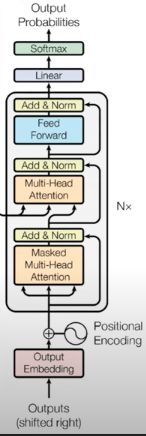

**Tip**: Do not use softmax, the Net should return logits. It's a convention.

In [ ]:

class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        """Same as Encoder"""
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(x)

        return out

    def forward2(self, x, enc_out, src_mask, trg_mask):
        """Same as Encoder"""
        N, seq_len = x.shape
        pos_emb = self.position_embeddinq(torch.arange(seq_len).expand(N,seq_len).to(self.device))
        word_emb = self.word_embedding(x)
        out = self.dropout(pos_emb + word_emb)
        for layer in self.layers:
          out = layer(out, enc_out, enc_out, src_mask, trg_mask)
        return self.fc_out(out)
        

## Full Architecture

In [ ]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=512,
        num_layers=6,
        forward_expansion=4,
        heads=8,
        dropout=0,
        device="cpu",
        max_length=100,
    ):

        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        """src is a tensor containing sequences of tokens. Some sequences have been padded.
        
        The purpose of the src_mask is to mask those padded tokens.
        This mask is used both during training and inference time.
        """
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # (N, 1, 1, src_len)
        return src_mask.to(self.device)

    
    def make_trg_mask(self, trg):
        """trg is a tensor containing sequences of tokens which have been predicted.

        trg mask is used only during training.
        """
        # Bonus: Why do we use a lower triangular matrix?
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out


## Training

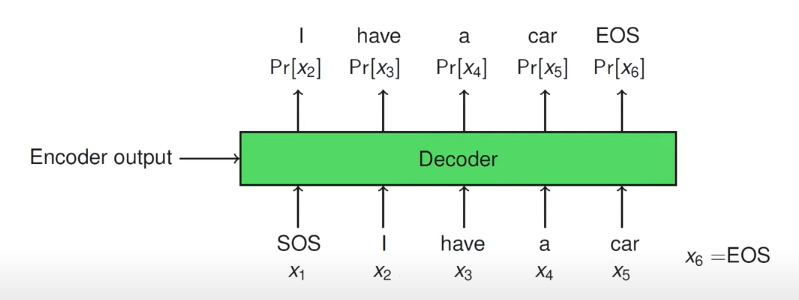

During training we use teacher forcing: instead of forward passing the number of time required to complete the sentence, we predict for each word the next word at once, in a single forward pass.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# 0 : pad, 1: Start of Sentence, 2: End of sentence
# Those lists of token_ids are created by the tokenizer
x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(
    device
)
trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]]).to(device)

src_pad_idx = 0
trg_pad_idx = 0
src_vocab_size = 10
trg_vocab_size = 10
model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device).to(
    device
)

# Why do we need :-1 here?
out = model(x, trg[:, :-1])
print(out.shape)

# Then we copmpute the CrossEntropy between the output and the trg[:, 1:]
print(out)

cuda
torch.Size([2, 7, 10])
tensor([[[ 0.1986,  0.3026, -0.2095,  0.4242,  0.0828, -0.0306,  0.1478,
           0.0957, -0.4253,  0.7040],
         [-0.4333,  0.6593,  0.3000,  0.6156,  0.4058,  0.3263,  0.1628,
           0.6657,  0.1233,  0.0129],
         [-0.0249,  0.6238,  0.2603, -0.6234,  0.5367, -0.0791,  0.9339,
           0.4966, -0.5296,  0.2047],
         [-0.0868,  0.8859,  0.3526, -0.5664,  0.1994, -0.0680,  0.5194,
           0.1948, -0.1079,  0.2125],
         [-0.7637,  1.1369,  0.5734, -0.4205,  0.7608,  0.1212,  0.0638,
           0.8706, -0.0429, -0.2778],
         [-0.8046,  1.1530,  1.0586,  0.0354, -0.0196,  0.5372,  0.8595,
           0.7816, -0.8339, -0.3586],
         [-0.7497,  1.6225,  1.4269, -0.3378, -0.3274,  0.5131,  0.7014,
           0.4834,  0.3245,  0.0052]],

        [[ 0.1342,  0.3344, -0.0075,  0.5034,  0.0947, -0.1110,  0.1940,
           0.2224, -0.1202,  0.4543],
         [-0.6726,  1.1885,  0.2607,  0.2989,  0.4592,  0.0876,  0.6825,
         

**Questions**:
- How does the transfomer architecture enables parallel training? What is teacher forcing? Why is the inference much slower than training in a sense?
- What are the differences between queries and keys?
- What are the differences with Bert and GPT?

**Bonus**
- Hide the init in the SelfAttention class. and write and __init__2
- Generate a dataset of tokens. Train a transformer which reverse the order of the tokens.
- Why do we add the embedding instead of concatenating them?
- How does transformer complexity vary with sequence length?
- Why bias=False in the self attention layer?
- What would happen if you train the attention architecture with sequence of len of 512, and then try to use it with sequences of 1000 tokens?
- type the code with https://github.com/patrick-kidger/torchtyping 


inspired from : https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/more_advanced/transformer_from_scratch/transformer_from_scratch.py

  3%|▎         | 3/100 [00:00<00:04, 20.25it/s]


epochs: 0
batch_num:0
loss:2.5376970767974854



  5%|▌         | 5/100 [00:00<00:04, 20.76it/s]


epochs: 1
batch_num:0
loss:1.592315912246704



  3%|▎         | 3/100 [00:00<00:04, 21.32it/s]


epochs: 2
batch_num:0
loss:0.6426049470901489



  3%|▎         | 3/100 [00:00<00:04, 21.15it/s]


epochs: 3
batch_num:0
loss:0.05936406925320625



  3%|▎         | 3/100 [00:00<00:04, 21.24it/s]


epochs: 4
batch_num:0
loss:0.013786298222839832



100%|██████████| 100/100 [00:04<00:00, 20.96it/s]


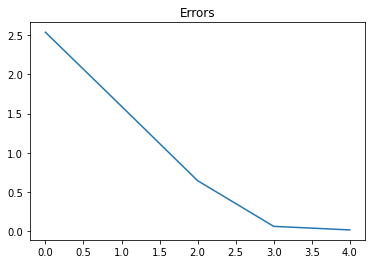

100%|██████████| 1/1 [00:00<00:00, 54.01it/s]

tensor([[3, 8, 5, 3, 7, 4, 6, 6, 8, 3],
        [4, 9, 4, 5, 6, 7, 5, 9, 9, 4]], device='cuda:0')
tensor([[3, 8, 5, 3, 7, 4, 6, 6, 8, 3],
        [4, 9, 4, 5, 6, 7, 5, 9, 9, 4]], device='cuda:0')


In [ ]:
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

param = {"batch_size": 100, 
         "src_pad_idx": 0 , 
         "trg_pad_idx": 0,
         "num_train_data": 10000,
         "seq_len":10,
         "vocab_size": 10, 
         "epochs": 5, 
         "num_eval_data": 2,
         "embed_size":20,
         "num_layers":6,
         "forward_expansion":4,
         "heads":5,
         "dropout":0,
         "device":device,
         "max_length":100,}

sequences_train = torch.randint(3,param["vocab_size"],(param["num_train_data"], param["seq_len"]) )
sequences_eval = torch.randint(3,param["vocab_size"],(param["num_eval_data"], param["seq_len"]) )


class SequenceDataset(Dataset):
    # Take a tensor of tokens of size (num_seq, seq_len).
    # Add a init token to each sequences.
    # When we call __getitem__, return the sequences and the sequences flipped.
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.cat((torch.ones(1, dtype=torch.long),self.sequences[idx])), torch.cat((torch.ones(1, dtype=torch.long),torch.flip(self.sequences[idx], dims=(0,))))


training_data = SequenceDataset(sequences_train)
train_dataloader = DataLoader(training_data, batch_size=param["batch_size"])

eval_data = SequenceDataset(sequences_eval)
eval_dataloader = DataLoader(eval_data, batch_size=param["batch_size"])

model = Transformer(
    param["vocab_size"], 
    param["vocab_size"], 
    param["src_pad_idx"], 
    param["trg_pad_idx"], 
    embed_size=param["embed_size"],
    num_layers=param["num_layers"],
    forward_expansion=param["forward_expansion"],
    heads=param["heads"],
    dropout=param["dropout"],
    device=param["device"],
    max_length=param["max_length"]).to(
    device
)
model.train()
loss_cross = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

errors =  []
for epoch in range(param["epochs"]):
  for batch, (X, y) in  enumerate(tqdm(train_dataloader)):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X, y[:,:-1])
    loss = loss_cross(pred.reshape(param["batch_size"]*(param["seq_len"]), param["vocab_size"]), y[:,1:].reshape(param["batch_size"]*(param["seq_len"])))

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch%100 == 0:
      errors.append(loss.item())
      print(f"\nepochs: {epoch}\nbatch_num:{batch}\nloss:{loss}\n")

plt.plot(errors)
plt.title("Errors")
plt.show()

model.eval()
for batch, (X, y) in  enumerate(tqdm(eval_dataloader)):
    X, y = X.to(device), y.to(device)
    pred = torch.argmax(model(X, y[:,:-1]),dim=2)
    print(y[:,1:])
    print(pred)

In [ ]:
for batch, (X, y) in  enumerate(tqdm(eval_dataloader)):
    X, y = X.to(device), y.to(device)
    pred = model(X, y[:,:-1])
    print(X)
    print(y[:,1:])
    print(torch.nn.functional.softmax(pred))
    print(torch.argmax(pred,dim=2))

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
100%|██████████| 1/1 [00:00<00:00, 38.64it/s]

tensor([[1, 3, 8, 6, 6, 4, 7, 3, 5, 8, 3],
        [1, 4, 9, 9, 5, 7, 6, 5, 4, 9, 4]], device='cuda:0')
tensor([[3, 8, 5, 3, 7, 4, 6, 6, 8, 3],
        [4, 9, 4, 5, 6, 7, 5, 9, 9, 4]], device='cuda:0')
tensor([[[3.8968e-01, 2.7492e-01, 8.2526e-01, 9.9981e-01, 4.4619e-04,
          9.4600e-01, 4.5474e-01, 7.9196e-01, 7.3206e-01, 3.0645e-01],
         [5.6726e-01, 5.1911e-01, 4.8619e-01, 6.8444e-01, 2.2601e-01,
          7.7638e-01, 1.0115e-01, 6.9170e-01, 9.9988e-01, 2.9094e-04],
         [1.2684e-01, 5.3475e-01, 6.0682e-01, 6.1130e-01, 1.9029e-04,
          9.9870e-01, 2.8389e-01, 5.9471e-01, 8.9379e-01, 4.7705e-01],
         [9.0298e-01, 3.0018e-01, 7.3991e-01, 9.9851e-01, 7.9791e-01,
          1.1419e-03, 2.4446e-01, 9.0587e-01, 4.8815e-01, 8.0159e-01],
         [3.6045e-01, 2.9680e-01, 2.9073e-01, 8.9246e-01, 8.2307e-01,
          7.8355e-01, 4.6217e-04, 9.9600e-01, 8.9668e-01, 1.1001e-02],
         [8.5981e-01, 6.9327e-01, 6.3350e-01, 9.5915e-01, 9.9964e-01,
          4.1649e-01, 7